# Cleaning Housing and Crime Datasets

## Import Dependencies and Read In Files

In [6]:
#import necessary dependencies
import pandas as pd
import numpy as np
from sodapy import Socrata
import time
import kaggle
from matplotlib import pyplot as plt

# Import API token
from config import app_token

# SQL database connnection imports
from config import password
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

In [7]:
# read in csvs
raw_house_df = pd.read_csv('Resources/austinHousingData.csv')
raw_crime_df = pd.read_csv('Resources/Crime_Reports.csv')

/Users/nayely/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## API Calls

In [226]:
# #API call to get crime data - Takes about 13 minutes to run
# start = time.perf_counter()
# # create client variable with parameters
# client = Socrata('data.austintexas.gov',
#                  app_token=app_token)
# # retrieve data; look into limit ?get_all?
# results = client.get("fdj4-gpfu", limit=3000000)
# # Convert to pandas DataFrame
# raw_crime_df = pd.DataFrame.from_records(results)

# end = time.perf_counter()
# print(f'{end-start}')

476.3087814170012


In [ ]:
# #API call to get housing data
# kaggle.api.authenticate()
# kaggle.api.dataset_download_file('ericpierce/austinhousingprices', file_name='austinHousingData.csv',  path='Resources/')
# raw_house_df = pd.read_csv('Resources/austinHousingData.csv.zip')

## Housing Data

In [202]:
# preview df 
raw_house_df.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,...,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,...,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [203]:
#check row and column count of df 
raw_house_df.shape

(15171, 47)

In [204]:
#check dtypes
raw_house_df.dtypes

zpid                            int64
city                           object
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
homeType                       object
parkingSpaces                   int64
yearBuilt                       int64
latestPrice                   float64
numPriceChanges                 int64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
latestPriceSource              object
numOfPhotos                     int64
numOfAccessibilityFeatures      int64
numOfApplian

In [206]:
#Drop columns that are mostly 0 or not as applicable to analysis
house_df= raw_house_df.drop(['numOfAccessibilityFeatures','latestPriceSource','numOfPhotos','numOfSecurityFeatures','numOfPatioAndPorchFeatures','numOfWaterfrontFeatures', 'numOfWindowFeatures','numOfCommunityFeatures'], axis = 1)
house_df.shape

(15171, 39)

In [207]:
#what years were the houses sold? 
house_df['latest_saleyear'].unique()

array([2019, 2020, 2018, 2021])

In [208]:
#what are the homeTypes? normalize=True provides the percentage
#With normalize set to True, returns the relative frequency by dividing all values by the sum of values.
house_df['homeType'].value_counts(normalize=True)


Single Family            0.938699
Condo                    0.030980
Townhouse                0.011469
Multiple Occupancy       0.006328
Vacant Land              0.005471
Residential              0.002439
Apartment                0.002439
Mobile / Manufactured    0.001121
MultiFamily              0.000659
Other                    0.000395
Name: homeType, dtype: float64

In [209]:
# Single Family, Condo and Townhouse make up most of the data, we are going to drop the rest
house_df = house_df.loc[((house_df['homeType'] == 'Single Family') | (house_df['homeType'] == 'Condo')) | (house_df['homeType'] == 'Townhouse')]
house_df.shape

(14885, 39)

In [210]:
# Only Austin houses
austin_house_df=house_df.loc[house_df['city'] == 'austin']
austin_house_df.shape

(14737, 39)

In [211]:
#check if there are null values 
austin_house_df[austin_house_df.isnull().any(axis = 1)]

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage


In [213]:
#create a df with school columns we could use in an additional analysis 
df_school_housing = austin_house_df[["city","streetAddress", "zipcode","description","latitude",
                        "longitude","homeType","yearBuilt","latestPrice",
                        "numOfPrimarySchools","numOfElementarySchools",
                        "numOfMiddleSchools","numOfHighSchools","avgSchoolDistance",
                        "avgSchoolRating","avgSchoolSize","MedianStudentsPerTeacher"
                       ]].copy()

In [214]:
#create a df with the relevant Austin housing information
df_housing=df[['zipcode', 'propertyTaxRate',
       'homeType', 'yearBuilt', 'latestPrice',
       'latest_saleyear', 'lotSizeSqFt', 'livingAreaSqFt', 'numOfBathrooms', 'numOfBedrooms',
       'numOfStories',"avgSchoolRating"]].copy()

In [215]:
#Sort by bathroom number
df_housing.sort_values(by='numOfBathrooms',ascending=False)

,zipcode,propertyTaxRate,homeType,yearBuilt,latestPrice,latest_saleyear,lotSizeSqFt,livingAreaSqFt,numOfBathrooms,numOfBedrooms,numOfStories,avgSchoolRating
2838,78731,1.98,Single Family,1967,745000.0,2020,10236.0,2137.0,27.0,4,1,7.000000
2316,78732,1.98,Single Family,2016,13500000.0,2018,710899.2,15394.0,13.0,6,1,8.333333
184,78732,1.98,Single Family,2014,4100000.0,2020,172497.6,9866.0,10.0,6,2,8.333333
2547,78733,1.98,Single Family,2014,2795000.0,2019,82328.4,11581.0,10.0,7,3,8.000000
613,78733,1.98,Single Family,2007,2750000.0,2018,43560.0,10611.0,10.0,6,2,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
6252,78746,1.98,Single Family,1999,949000.0,2018,14810.4,5187.0,0.0,5,2,9.500000
12993,78749,1.98,Single Family,2000,447000.0,2019,7187.0,3271.0,0.0,5,2,7.333333
4008,78741,1.98,Condo,2020,249000.0,2020,7318.0,1700.0,0.0,4,1,3.333333
2557,78733,1.98,Single Family,2018,829000.0,2018,103237.2,29440.0,0.0,1,2,8.000000


In [216]:
#Drop the bathroom outlier
df_housing.drop(2838,axis=0,inplace=True)

In [217]:
#new dataframe for MLM 
housing_mlm = df [["zipcode", "propertyTaxRate","latestPrice","latest_saleyear",
                  "lotSizeSqFt","livingAreaSqFt","numOfPrimarySchools",
                   "numOfElementarySchools","numOfMiddleSchools","numOfHighSchools",
                  "numOfBathrooms","numOfBedrooms","numOfStories"]].copy()

In [218]:
#convert clean_df to csv 
df_housing.to_csv(r'Resources/HousingData_clean.csv')

In [219]:
housing_mlm.to_csv(r'Resources/HousingData_MLM.csv')

## Crime Data

In [8]:
#code to view all rows
pd.set_option("display.max_rows", None)
#preview data
raw_crime_df.sample(5)

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,...,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
2242307,20193451321,DISTURBANCE - OTHER,3401,N,12/11/2019 05:24:00 PM,12/11/2019,1724.0,12/11/2019 05:24:00 PM,12/11/2019,1724.0,...,9.00,N,12/28/2019,NaN,NaN,3121376.0,3121376.0,30.257992,-97.720700,"(30.25799232, -97.72069992)"
989612,20143050507,DWI,2100,N,11/01/2014 03:17:00 AM,11/01/2014,317.0,11/01/2014 03:17:00 AM,11/01/2014,317.0,...,11.00,C,11/08/2014,NaN,NaN,3115952.0,3115952.0,30.267976,-97.737616,"(30.2679761, -97.73761583)"
203063,20045003552,INDECENCY WITH A CHILD/CONTACT,1709,N,01/23/2004 12:26:00 PM,01/23/2004,1226.0,01/23/2004 12:26:00 PM,01/23/2004,1226.0,...,334.00,NaN,03/02/2004,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1838404,20132411678,BURGLARY OF RESIDENCE,500,N,08/29/2013 08:20:00 PM,08/29/2013,2020.0,08/29/2013 09:39:00 PM,08/29/2013,2139.0,...,337.00,N,09/02/2013,220,Burglary,3093261.0,3093261.0,30.433936,-97.805166,"(30.43393568, -97.80516629)"
132136,20072300053,PUBLIC INTOXICATION,2300,N,08/18/2007 12:23:00 AM,08/18/2007,23.0,08/18/2007 12:23:00 AM,08/18/2007,23.0,...,23.16,C,08/22/2007,NaN,NaN,3118937.0,3118937.0,30.240887,-97.728889,"(30.24088691, -97.72888858)"


In [9]:
#removing spaces in column names 
raw_crime_df.columns = raw_crime_df.columns.str.replace(' ','_')
#create a year column for occurred date 
raw_crime_df['year'] = pd.DatetimeIndex(raw_crime_df['Occurred_Date']).year

In [10]:
#filter dataframe to be between 2018-2021
filtered_crime_df = raw_crime_df[raw_crime_df['year']>=2018]
filtered_crime_df = filtered_crime_df[filtered_crime_df['year']<=2021]
filtered_crime_df.shape

(405119, 28)

In [11]:
#how many unique values are there in highest offense description?
filtered_crime_df['Highest_Offense_Description'].nunique()

377

In [12]:
#check relative frequency by dividing all values by the sum of values
offense_counts=filtered_crime_df['Highest_Offense_Description'].value_counts(normalize=True)
offense_counts

FAMILY DISTURBANCE                               0.101244
BURGLARY OF VEHICLE                              0.090931
THEFT                                            0.079411
CRIMINAL MISCHIEF                                0.050686
AUTO THEFT                                       0.033652
ASSAULT W/INJURY-FAM/DATE VIOL                   0.032630
DISTURBANCE - OTHER                              0.026913
THEFT BY SHOPLIFTING                             0.026624
HARASSMENT                                       0.026118
ASSAULT WITH INJURY                              0.025128
DWI                                              0.021226
BURGLARY OF RESIDENCE                            0.018950
BURGLARY NON RESIDENCE                           0.018836
ASSAULT BY CONTACT                               0.017763
CRIMINAL TRESPASS                                0.017387
IDENTITY THEFT                                   0.015993
POSS CONTROLLED SUB/NARCOTIC                     0.015669
THEFT OF BICYC

In [13]:
#Sum offenses with a value of 0.0001 or higher
offense_counts[offense_counts >= 0.0001].sum()

0.9948138695050095

In [14]:
#Since the majority of offenses are higher than or equal to 0.001, will drop offenses that are lower than that
low_offense=offense_counts[offense_counts < 0.0001].index
filtered_crime_df = filtered_crime_df[filtered_crime_df['Highest_Offense_Description'].isin(low_offense) == False]
filtered_crime_df['Highest_Offense_Description'].nunique()

203

In [15]:
#check null values
#do we want to drop null values or do we want to drop the columns? 
filtered_crime_df.isnull().sum(axis = 0)

Incident_Number                     0
Highest_Offense_Description         0
Highest_Offense_Code                0
Family_Violence                     0
Occurred_Date_Time                  0
Occurred_Date                       0
Occurred_Time                       0
Report_Date_Time                    0
Report_Date                         0
Report_Time                         0
Location_Type                    1107
Address                             0
Zip_Code                         2657
Council_District                 4429
APD_Sector                       1675
APD_District                     1755
PRA                              2167
Census_Tract                     3711
Clearance_Status                47375
Clearance_Date                  47385
UCR_Category                   247759
Category_Description           247759
X-coordinate                     2063
Y-coordinate                     2063
Latitude                         7239
Longitude                        7239
Location    

In [16]:
#drop unneccessary columns for our analysis 
dropped_col_df= filtered_crime_df.drop(["Council_District","APD_Sector","APD_District","PRA","Occurred_Time","Report_Time"],axis = 1)
dropped_col_df.shape

(403018, 22)

In [17]:
#checking null valules of latitude -- why does rape disapear when latitude null values are dropped? 
lat_lookup = dropped_col_df.loc[dropped_col_df["Latitude"].isnull()].copy()
#looking at occurances of rape within null latitude values 
lat_lookup["Category_Description"].value_counts()

Rape                  2178
Theft                  238
Aggravated Assault     170
Burglary                53
Auto Theft              50
Robbery                 31
Name: Category_Description, dtype: int64

In [18]:
#dropping nulls of important columns -- dropping latitude will remove rape occurances 
clean_df = dropped_col_df.dropna(axis=0, subset=["Location_Type","Zip_Code","Census_Tract"
                                           ,"Latitude"])


In [19]:
clean_df["Category_Description"].unique()

array(['Theft', nan, 'Burglary', 'Aggravated Assault', 'Robbery',
       'Auto Theft', 'Murder'], dtype=object)

In [20]:
clean_df.shape

(393216, 22)

In [22]:
#replacing nulls for UCR_Category with zero 
clean_df[["UCR_Category"]] = clean_df[["UCR_Category"]].fillna('0')
#replacing nulls with "None"
clean_df[["Category_Description"]] = clean_df[["Category_Description"]].fillna('None')
#replacing nulls with "U" for unkown 
clean_df[["Clearance_Status"]] = clean_df[["Clearance_Status"]].fillna('U')
#replacing nulls with a random date so its obvious on visualizaitons 
clean_df[["Clearance_Date"]] = clean_df[["Clearance_Date"]].fillna('01/01/1888')

In [23]:
#convert occurred date time to datetime dtype
clean_df['Occurred_Date_Time'] =  pd.to_datetime(clean_df['Occurred_Date_Time'])
#create an hour column for the ocurred time
clean_df['hour'] = pd.DatetimeIndex(clean_df['Occurred_Date_Time']).hour
clean_df['hour'].head()


/Users/nayely/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/nayely/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


1     22
5     22
6     14
7     12
10    17
Name: hour, dtype: int64

In [24]:
#divide into time buckets
clean_df['hour_category']=pd.cut(clean_df['hour'],
    [0,12,18,21,23],
        labels=['Morning','Afternoon','Evening','Night'],
        include_lowest=True)

/Users/nayely/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [74]:
## Count of crime per zipcode for 2018-2021
zipcode_grouped_df = clean_df.groupby(['Zip_Code']).count()
zipcode_crimecount_df=zipcode_grouped_df['Highest_Offense_Code'].to_frame()
zipcode_crimecount_df.rename(columns={'Highest_Offense_Code':'Count_Of_Crimes_Per_Zip'}, inplace=True)
# Calculating Percentage of Crime Count per ZipCode
zipcode_crimecount_df['Percentage_Of_Total_Crime'] = (zipcode_crimecount_df['Count_Of_Crimes_Per_Zip'] / 
                  zipcode_crimecount_df['Count_Of_Crimes_Per_Zip'].sum()) * 100
  
# Show the dataframe
zipcode_crimecount_df.sort_values(by=['Count_Of_Crimes_Per_Zip'], ascending=False)

,Count_Of_Crimes_Per_Zip,Percentage_Of_Total_Crime
Zip_Code,,
78741.0,31311,7.962799
78753.0,30950,7.870992
78758.0,30780,7.827759
78704.0,25670,6.528219
78701.0,25580,6.505330
78745.0,23149,5.887095
78723.0,21465,5.458832
78744.0,21206,5.392965
78702.0,17131,4.356639


In [30]:
group_df = clean_df.groupby(['Zip_Code','hour_category']).count()
group_df.head()

Incident_Number  Highest_Offense_Description  \
Zip_Code hour_category                                                 
78610.0  Morning                     10                           10   
         Afternoon                    8                            8   
         Evening                      3                            3   
         Night                        3                            3   
78612.0  Morning                      1                            1   

                        Highest_Offense_Code  Family_Violence  \
Zip_Code hour_category                                          
78610.0  Morning                          10               10   
         Afternoon                         8                8   
         Evening                           3                3   
         Night                             3                3   
78612.0  Morning                           1                1   

                        Occurred_Date_Time  Occurred_Date  Report_Date_Time  \
Zip_Code hour_category                                                        
78610.0  Morning                        10             10                10   
         Afternoon                       8              8                 8   
         Evening                         3              3                 3   
         Night                           3              3                 3   
78612.0  Morning                         1              1                 1   

                        Report_Date  Location_Type  Address  ...  \
Zip_Code hour_category                                       ...   
78610.0  Morning                 10             10       10  ...   
         Afternoon                8              8        8  ...   
         Evening                  3              3        3  ...   
         Night                    3              3        3  ...   
78612.0  Morning                  1              1        1  ...   

                        Clearance_Date  UCR_Category  Category_Description  \
Zip_Code hour_category                                                       
78610.0  Morning                    10            10                    10   
         Afternoon                   8             8                     8   
         Evening                     3             3                     3   
         Night                       3             3                     3   
78612.0  Morning                     1             1                     1   

                        X-coordinate  Y-coordinate  Latitude  Longitude  \
Zip_Code hour_category                                                    
78610.0  Morning                  10            10        10         10   
         Afternoon                 8             8         8          8   
         Evening                   3             3         3          3   
         Night                     3             3         3          3   
78612.0  Morning                   1             1         1          1   

                        Location  year  hour  
Zip_Code hour_category                        
78610.0  Morning              10    10    10  
         Afternoon             8     8     8  
         Evening               3     3     3  
         Night                 3     3     3  
78612.0  Morning               1     1     1  

[5 rows x 22 columns]

In [36]:
dfp = group_df.pivot_table(index='Zip_Code', columns='hour_category', values=['Incident_Number'], aggfunc='sum')
dfp.head()
dfp.columns = dfp.columns.droplevel(0) #remove amount
dfp.columns.name = None               #remove categories
dfp.head()

,Morning,Afternoon,Evening,Night
Zip_Code,,,,
78610.0,10,8,3,3
78612.0,1,0,1,0
78613.0,641,802,365,126
78616.0,1,0,0,0
78617.0,1463,972,603,366


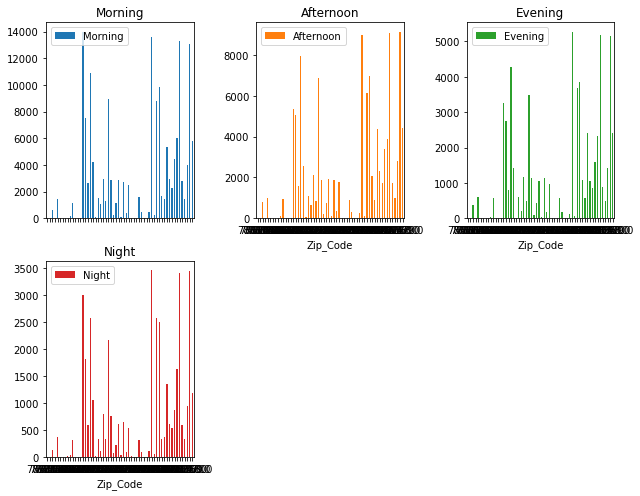

In [39]:
#Plot table
dfp.plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
plt.tight_layout()

In [ ]:
#convert clean_df to csv 
clean_df.to_csv(r'Resources/2018To2021CrimeData_clean.csv')

## Export to SQL

In [ ]:
#set parameters for sql database
params = {"host": "localhost", "user": "postgres", "password": password, "port": 5432}

In [ ]:
#create MyDB class
class MyDB(object):
    def __init__(self):
        self.params = params
    
    #create a function to create a new database in sql
    def create_new_db(self, newdb):
        user, host, port = self.params['user'], self.params['host'], self.params['port']
        pw = self.params['password']
        url = 'postgresql://{}:{}@{}:{}/{}'
        url = url.format(user, pw, host, port, newdb)
        
        self.engine = create_engine(url, client_encoding='utf8')
        if not database_exists(self.engine.url):
            create_database(self.engine.url)
    
    #create a function to export crime data to sql
    def df1postgres(self, df):
        url = 'postgresql://{}:{}@{}:{}/{}'
        url = url.format(params['user'], params['password'], params['host'], params['port'], 'test') #name of db
        conn = create_engine(url)
        df.to_sql(name='crime_data', con=conn, if_exists='replace', index=False, chunksize=100)
    
    #create a function to export housing data to sql
    def df2postgres(self, df):
        url = 'postgresql://{}:{}@{}:{}/{}'
        url = url.format(params['user'], params['password'], params['host'], params['port'], 'test') #name of db
        conn = create_engine(url)
        df.to_sql(name='housing_data', con=conn, if_exists='replace', index=False, chunksize=10)
        
        return conn

In [ ]:
db = MyDB()
db.create_new_db('test') #name of db

In [ ]:
#Crime dataframe
con1 = db.df1postgres(crime_data)

#Crime by zipcode dataframe
con2 = db.df2postgres(zipcode_crimecount_df)

#Housing dataframe
con3 = db.df2postgres(clean_df)

#create connection 
conn = psycopg2.connect(dbname='test', user=params['user'], password=password, host=params['host'])

# check if connection to import crime data works
# crime_df = pd.read_sql_query('select * from "crime_data" limit 1',con=conn) 

# check if connection to import housing data works
# housing_df = pd.read_sql_query('select * from "housing_data" limit 1',con=conn) 

#insert sql query to merge crime and housing dataframe before importing to jupyter notebook

#close connection
conn.close()